<a href="https://www.kaggle.com/code/seunayegboyin/customer-segmentation-with-kmeans-and-pca?scriptVersionId=121975099" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sns.set()

In [2]:
test=pd.read_csv('../input/customer-segmentation/test.csv')
test.sample(6)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
2514,467595,Female,No,25,Yes,Healthcare,0.0,Low,1.0,Cat_6
2274,466759,Female,No,26,No,Healthcare,2.0,Low,NaN,Cat_6
294,459961,Male,Yes,48,Yes,Artist,8.0,Low,3.0,Cat_2
262,459822,Female,No,39,Yes,Engineer,1.0,Low,1.0,Cat_4
1498,464042,Female,Yes,38,Yes,Artist,8.0,Low,2.0,Cat_6
2241,466650,Female,No,27,No,Healthcare,8.0,Low,3.0,Cat_4


# **Data Exploration**

In [3]:
test.describe()

,ID,Age,Work_Experience,Family_Size
count,2627.000000,2627.000000,2358.000000,2514.000000
mean,463433.918919,43.649791,2.552587,2.825378
std,2618.245698,16.967015,3.341094,1.551906
min,458989.000000,18.000000,0.000000,1.000000
25%,461162.500000,30.000000,0.000000,2.000000
50%,463379.000000,41.000000,1.000000,2.000000
75%,465696.000000,53.000000,4.000000,4.000000
max,467968.000000,89.000000,14.000000,9.000000


In [4]:
train=pd.read_csv('../input/customer-segmentation/train.csv',index_col=[0])
train.sample(6)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
467195,Male,Yes,27,Yes,Executive,NaN,High,2.0,Cat_6,A
466200,Male,Yes,51,Yes,Doctor,8.0,Average,3.0,Cat_4,B
466256,Female,Yes,65,Yes,Engineer,1.0,Low,1.0,Cat_6,B
466864,Female,No,32,No,Homemaker,8.0,Low,1.0,Cat_6,D
463128,Male,Yes,73,Yes,Lawyer,0.0,High,4.0,Cat_6,A
466811,Male,No,22,No,Healthcare,0.0,Low,NaN,Cat_4,D


In [5]:
train.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 462809 to 461879
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 693.3+ KB


In [7]:
train.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [8]:
train['Ever_Married'].fillna(method='ffill',inplace=True)
train['Profession'].fillna(method='ffill',inplace=True)
train['Graduated'].fillna(method='bfill',inplace=True)
train['Work_Experience'].fillna(method='bfill',inplace=True)
train['Family_Size'].fillna(method='bfill',inplace=True)


In [9]:
train.isna().sum()

Gender              0
Ever_Married        0
Age                 0
Graduated           0
Profession          0
Work_Experience     0
Spending_Score      0
Family_Size         0
Var_1              76
Segmentation        0
dtype: int64

# **Data Preprocessing**

In [10]:
train1=train[['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size']]
train1

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
ID,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0
462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0
...,...,...,...,...,...,...,...,...
464018,Male,No,22,No,Artist,0.0,Low,7.0
464685,Male,No,35,No,Executive,3.0,Low,4.0
465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0


In [11]:
train1.groupby('Profession').mean()

,Age,Work_Experience,Family_Size
Profession,,,
Artist,46.189432,2.701761,2.523288
Doctor,37.311522,2.621622,2.880512
Engineer,41.762784,2.562500,2.974432
Entertainment,43.056075,2.686397,2.785047
Executive,51.089256,2.305785,3.418182
Healthcare,27.038433,2.557280,3.637103
Homemaker,38.244000,5.952000,2.316000
Lawyer,74.630503,1.391509,1.992138
Marketing,37.006689,2.545151,3.073579


In [12]:
train1.groupby('Ever_Married').mean()

,Age,Work_Experience,Family_Size
Ever_Married,,,
No,32.377764,2.953078,2.990436
Yes,51.324651,2.381406,2.752224


In [13]:
train1.groupby('Gender').mean()

,Age,Work_Experience,Family_Size
Gender,,,
Female,42.911531,2.810463,2.758422
Male,43.925968,2.459814,2.927553


In [14]:
train1.groupby('Spending_Score').mean()

,Age,Work_Experience,Family_Size
Spending_Score,,,
Average,46.868288,2.513171,3.102330
High,57.777138,2.162007,2.989309
Low,38.523165,2.774908,2.714842


In [15]:
train1['Profession']=train1['Profession'].map({'Artist':0, 
                                               'Doctor':1, 
                                               'Engineer':2,
                                               'Entertainment':3,
                                               'Executive':4,
                                               'Healthcare':5,
                                               'Homemaker':6,
                                               'Lawyer':7, 
                                               'Marketing':8})
train1['Spending_Score']=train1['Spending_Score'].map({'Average':0,
                                                       'High':1,
                                                       'Low':2})
train1['Gender']=train1['Gender'].map({'Female':0,
                                       'Male':1})
train1['Ever_Married']=train1['Ever_Married'].map({'No':0,
                                                  'Yes':1})
train1['Graduated']=train1['Graduated'].map({'No':0,
                                                  'Yes':1})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [16]:
train1.sample(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
ID,,,,,,,,
462982,1,1,41,0,1,2.0,0,4.0
461703,0,1,29,1,5,0.0,2,2.0
464855,0,1,37,0,2,4.0,0,9.0
459446,1,1,36,0,3,0.0,0,3.0
460434,1,1,57,1,0,3.0,1,3.0


In [17]:
train1.corr().round(2)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
Gender,1.00,0.11,0.03,-0.03,0.03,-0.05,-0.05,0.06
Ever_Married,0.11,1.00,0.56,0.19,-0.14,-0.08,-0.62,-0.08
Age,0.03,0.56,1.00,0.23,0.04,-0.17,-0.27,-0.27
Graduated,-0.03,0.19,0.23,1.00,-0.29,0.04,-0.15,-0.22
Profession,0.03,-0.14,0.04,-0.29,1.00,-0.02,0.23,0.08
Work_Experience,-0.05,-0.08,-0.17,0.04,-0.02,1.00,0.04,-0.06
Spending_Score,-0.05,-0.62,-0.27,-0.15,0.23,0.04,1.00,-0.11
Family_Size,0.06,-0.08,-0.27,-0.22,0.08,-0.06,-0.11,1.00


<AxesSubplot:title={'center':'Correlation Map'}>

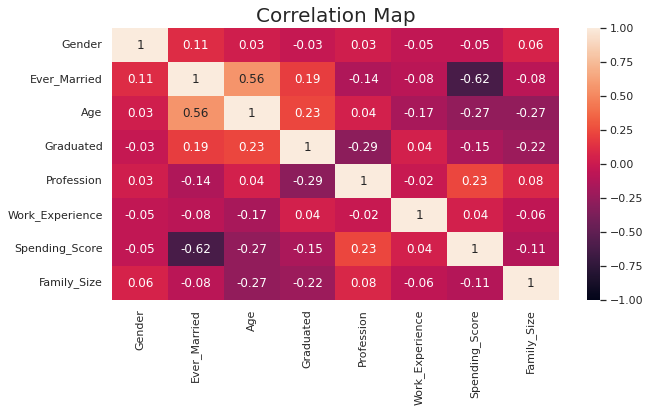

In [18]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.title("Correlation Map",fontsize=20)
sns.heatmap(train1.corr().round(2),vmin=-1,vmax=1,annot=True)

# **Standadization**

In [19]:
stand=StandardScaler()
stand.fit(train1)

StandardScaler()

In [20]:
stand.transform(train1)

array([[ 0.90916397, -1.18795509, -1.28462344, ..., -0.4784402 ,
         0.754462  ,  0.75103849],
       [-1.0999116 ,  0.84178266, -0.32715082, ..., -0.4784402 ,
        -1.60301259,  0.09738385],
       [-1.0999116 ,  0.84178266,  1.40826831, ..., -0.4784402 ,
         0.754462  , -1.20992543],
       ...,
       [-1.0999116 , -1.18795509, -0.62636101, ..., -0.4784402 ,
         0.754462  , -1.20992543],
       [-1.0999116 , -1.18795509, -0.98541324, ..., -0.4784402 ,
         0.754462  ,  0.75103849],
       [ 0.90916397,  0.84178266, -0.38699286, ..., -0.77404868,
        -1.60301259,  0.09738385]])

# **Hierachitical**

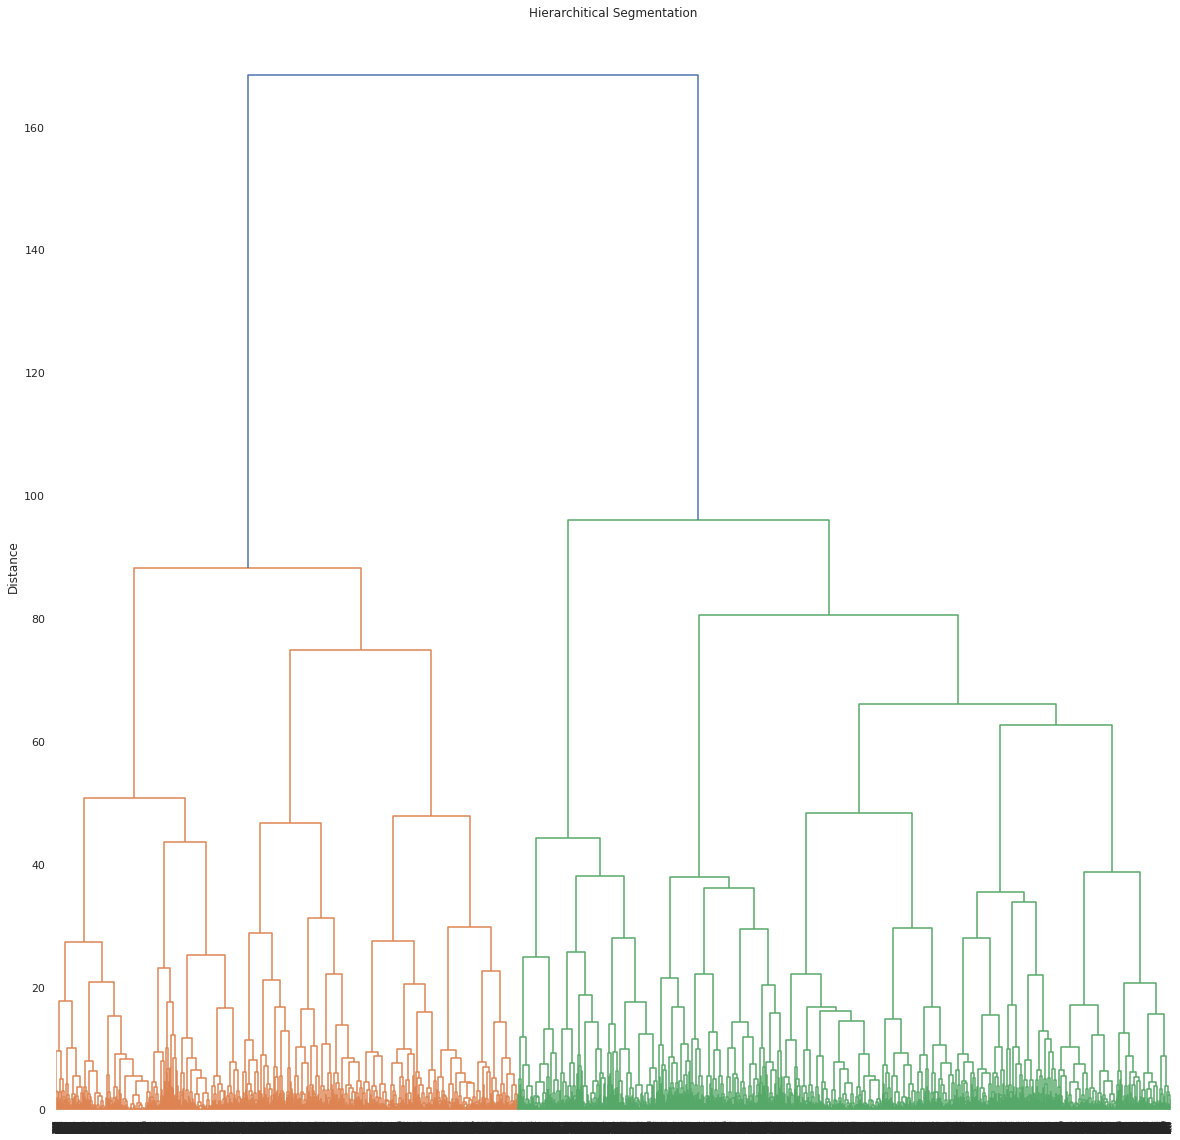

In [21]:
link=linkage(stand.transform(train1),'ward')
plt.figure(figsize=(20,20))
dendrogram(link,p=5)
plt.ylabel('Distance')
plt.title('Hierarchitical Segmentation')
plt.show()

In [22]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 462809 to 461879
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   int64  
 1   Ever_Married     8068 non-null   int64  
 2   Age              8068 non-null   int64  
 3   Graduated        8068 non-null   int64  
 4   Profession       8068 non-null   int64  
 5   Work_Experience  8068 non-null   float64
 6   Spending_Score   8068 non-null   int64  
 7   Family_Size      8068 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 567.3 KB


# **K-Means Clustering**

In [23]:
train1[['Work_Experience','Family_Size']]=train1[['Work_Experience','Family_Size']].astype('int32')
#train1['Family_Size']=train1['Family_Size'].asty

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [24]:
stand=StandardScaler()
stand.fit_transform(train1)

array([[ 0.90916397, -1.18795509, -1.28462344, ..., -0.4784402 ,
         0.754462  ,  0.75103849],
       [-1.0999116 ,  0.84178266, -0.32715082, ..., -0.4784402 ,
        -1.60301259,  0.09738385],
       [-1.0999116 ,  0.84178266,  1.40826831, ..., -0.4784402 ,
         0.754462  , -1.20992543],
       ...,
       [-1.0999116 , -1.18795509, -0.62636101, ..., -0.4784402 ,
         0.754462  , -1.20992543],
       [-1.0999116 , -1.18795509, -0.98541324, ..., -0.4784402 ,
         0.754462  ,  0.75103849],
       [ 0.90916397,  0.84178266, -0.38699286, ..., -0.77404868,
        -1.60301259,  0.09738385]])

In [25]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,random_state=42)
    kmeans=kmeans.fit(stand.fit_transform(train1))
    wcss.append(kmeans.inertia_)


In [26]:
wcss

[64543.99999999979,
 50037.38126426161,
 44448.974046207215,
 38880.912985274954,
 35630.93586418221,
 33209.373055845026,
 31135.859295472183,
 29321.07088568421,
 27651.31240522796,
 26350.8487363905]

Text(0.5, 0, 'Segmentation Range')

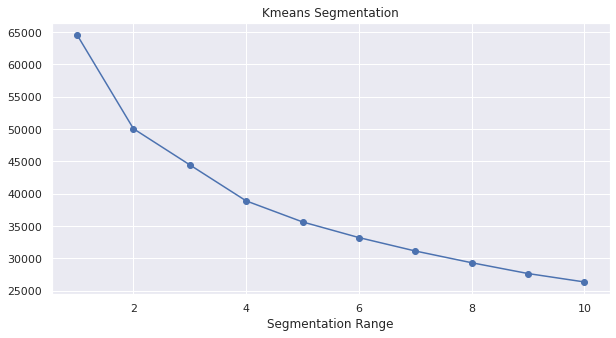

In [27]:
plt.figure(figsize=(10,5))
plt.plot(range(1,11),wcss,marker='o')
plt.title('Kmeans Segmentation')
plt.xlabel('Segmentation Range')

In [28]:
kmeans=KMeans(n_clusters=4,random_state=40)
kmeans.fit(stand.fit_transform(train1))
kmeans.labels_

array([3, 1, 0, ..., 2, 3, 1], dtype=int32)

In [29]:
kmeans_seg=pd.DataFrame(train1)
kmeans_seg["segmentation"]=kmeans.labels_
kmeans_seg

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,segmentation
ID,,,,,,,,,
462809,1,0,22,0,5,1,2,4,3
462643,0,1,38,1,2,1,0,3,1
466315,0,1,67,1,2,1,2,1,0
461735,1,1,67,1,7,0,1,2,0
462669,0,1,40,1,3,0,1,6,1
...,...,...,...,...,...,...,...,...,...
464018,1,0,22,0,0,0,2,7,3
464685,1,0,35,0,4,3,2,4,3
465406,0,0,33,1,5,1,2,1,2


In [30]:
kmeans_seg_grp=kmeans_seg.groupby('segmentation').mean().round(2)
kmeans_seg_grp

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
segmentation,,,,,,,,
0,0.66,0.96,69.18,0.56,5.43,1.33,1.46,2.15
1,0.59,1.00,46.70,0.76,1.47,2.59,0.24,3.20
2,0.45,0.37,40.33,0.91,1.52,3.49,1.99,1.84
3,0.54,0.09,27.30,0.17,4.22,2.47,1.97,3.98


In [31]:
kmeans_seg_grp.rename({0:'Average',1:'Low',2:'work & spend',3:'Good Profeesion'},inplace=True)
kmeans_seg_grp

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
segmentation,,,,,,,,
Average,0.66,0.96,69.18,0.56,5.43,1.33,1.46,2.15
Low,0.59,1.00,46.70,0.76,1.47,2.59,0.24,3.20
work & spend,0.45,0.37,40.33,0.91,1.52,3.49,1.99,1.84
Good Profeesion,0.54,0.09,27.30,0.17,4.22,2.47,1.97,3.98


# **PCA**

In [32]:
pca=PCA()
pca.fit(stand.fit_transform(train1))
pca.explained_variance_ratio_.cumsum()

array([0.32915959, 0.47827754, 0.61373984, 0.72004623, 0.82602921,
       0.9007203 , 0.95118497, 0.98280008, 1.        ])

Text(0.5, 0, 'Clustering Range')

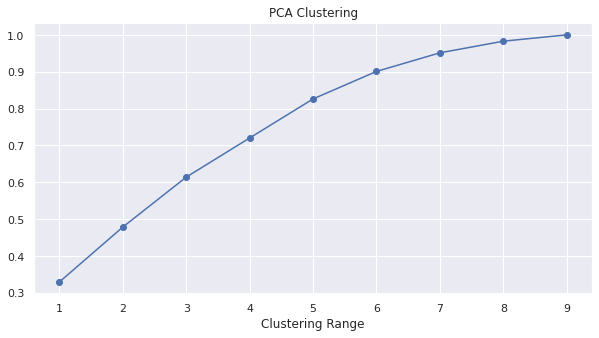

In [33]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10),pca.explained_variance_ratio_.cumsum(),marker='o')
plt.title('PCA Clustering')
plt.xlabel("Clustering Range")

In [34]:
pca=PCA(n_components=4)
pca.fit(stand.fit_transform(train1))
pca.components_

array([[-0.0646317 , -0.49770159, -0.4584958 , -0.23959878,  0.10542151,
         0.08830969,  0.39278673,  0.15529094,  0.53214744],
       [ 0.31436367,  0.14034008,  0.06006832, -0.53137565,  0.47770966,
        -0.33596355, -0.14061877,  0.47561177, -0.09194368],
       [ 0.10769139,  0.14211745, -0.3539061 ,  0.0664359 , -0.55198871,
         0.10377437, -0.47198737,  0.52461058,  0.15840752],
       [-0.07321598,  0.12810269, -0.02476415, -0.19968484,  0.31539631,
         0.89511816, -0.15261972,  0.03968891, -0.11028364]])

In [35]:
train1.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'segmentation'],
      dtype='object')

In [36]:
pca_seg=pd.DataFrame(pca.components_,index=['comp 1','comp 2','comp 3','comp 4'],columns=['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'segmentation']).round(3)
pca_seg

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,segmentation
comp 1,-0.065,-0.498,-0.458,-0.240,0.105,0.088,0.393,0.155,0.532
comp 2,0.314,0.140,0.060,-0.531,0.478,-0.336,-0.141,0.476,-0.092
comp 3,0.108,0.142,-0.354,0.066,-0.552,0.104,-0.472,0.525,0.158
comp 4,-0.073,0.128,-0.025,-0.200,0.315,0.895,-0.153,0.040,-0.110


Text(0.5, 1.0, 'Component Map')

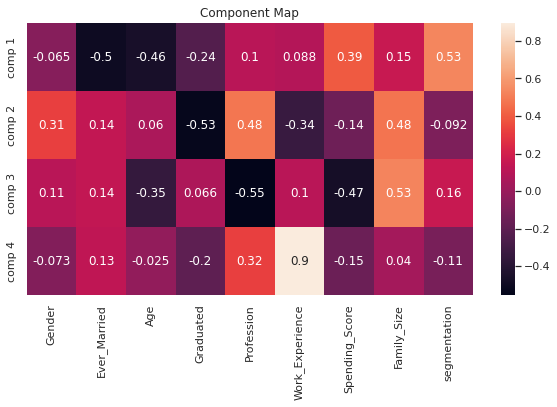

In [37]:
plt.figure(figsize=(10,5))
sns.heatmap(pca_seg,annot=True)
plt.title('Component Map')